In [1]:
!nvidia-smi

Mon Apr  7 09:57:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.03             Driver Version: 572.60         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P3             13W /   55W |       0MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Test Accuracy: 0.6416
Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.53      0.58   1723315
         1.0       0.64      0.74      0.69   1943352

    accuracy                           0.64   3666667
   macro avg       0.64      0.64      0.63   3666667
weighted avg       0.64      0.64      0.64   3666667



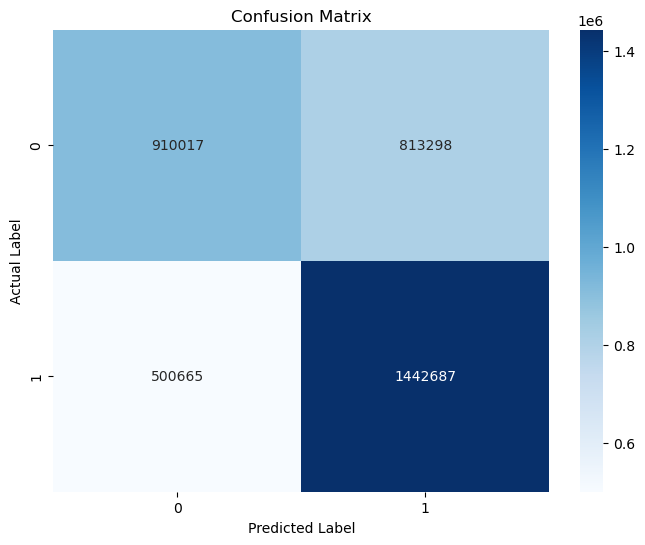

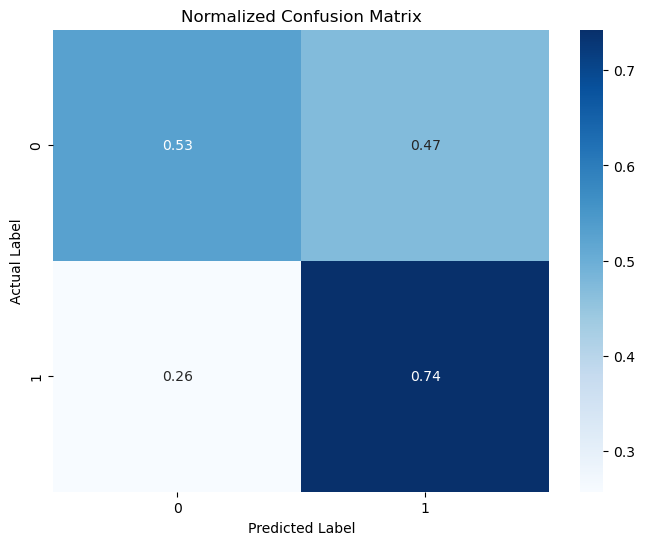

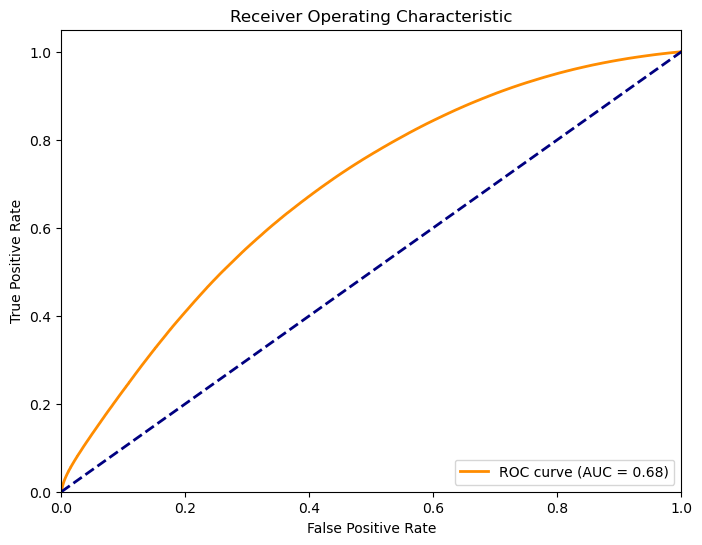

CPU times: user 30.9 s, sys: 3.67 s, total: 34.5 s
Wall time: 51.1 s


In [1]:
%%time
import cudf
import cuml
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Load pre-split datasets
higgs_train = cudf.read_csv("higgs_train.csv")
higgs_test = cudf.read_csv("higgs_test.csv")

# Separate features and labels
X_train = higgs_train.drop('class_label', axis=1)
y_train = higgs_train['class_label']
X_test = higgs_test.drop('class_label', axis=1)
y_test = higgs_test['class_label']

# -----------------------------
# Train logistic regression model
# -----------------------------
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred = lr_model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")

# -----------------------------
# Classification report & confusion matrix
# -----------------------------

# Convert predictions and labels to pandas
y_test_pd = y_test.to_pandas()
y_pred_pd = y_pred.to_pandas()

# Classification report
print("Classification Report:")
print(classification_report(y_test_pd, y_pred_pd))

# Confusion Matrix
cm = confusion_matrix(y_test_pd, y_pred_pd)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap='Blues')
plt.title("Normalized Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()

# -----------------------------
# ROC-AUC Curve
# -----------------------------
# Get predicted probabilities
y_proba = lr_model.predict_proba(X_test)

# Convert to pandas
if hasattr(y_proba, "to_pandas"):
    y_proba = y_proba.to_pandas()

# Probabilities for positive class
y_score = y_proba.iloc[:, 1]

# Compute ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test_pd, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
